<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/transformer/cifar10_pytorch_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer (ViT) による画像分類

### はじめに

前回、CNN（畳み込みニューラルネットワーク）を使用してCIFAR-10データセットの分類を行いました。CNNでは、畳み込み層やプーリング層を使用して画像から特徴量を抽出し、最終的に分類を行います。しかし、今回の課題では畳み込み層やプーリング層を使わずに、同様のタスクをVision Transformer (ViT) を使って実行してみましょう。

### ViTとは

Vision Transformer (ViT) は、自然言語処理で成功を収めたTransformerモデルを画像認識に適用したものです。TransformerはAttentionメカニズムを使用して、入力データの重要な部分に焦点を当てることで特徴量を抽出します。これにより、ViTは画像全体を処理するのではなく、部分的な情報からも高い特徴抽出能力を発揮します。

### CNNとViTの特徴量抽出方法の違い

CNNの場合、以下の２層をいくつか用いて特徴量を抽出します。

- **畳み込み層**<br>
異なるフィルタを画像に適用して、エッジやテクスチャなどの低レベルの特徴を検出します。
- **プーリング層**<br>
空間的な次元を削減し、計算量を減らしながら重要な特徴を保持します。

ViT の場合は、以下の手順で特徴量を抽出します。

- **パッチ分割**<br>画像を小さな固定サイズのパッチに分割します。例えば、32x32 の画像を 4x4 のパッチに分割すると、合計 64 個のパッチが得られます。
- **パッチ埋め込み** <br>
各パッチを固定長のベクトルに変換します。これはCNNの畳み込み層の役割に近いです。
- **位置エンコーディング** <br>
パッチの位置情報を加えるために、各パッチに位置エンコーディングを追加します。
- **Transformerエンコーダ** <br>
複数の Encoder ブロックを通じて、各パッチ間の相互関係を学習します。これにより、画像全体の文脈を考慮した特徴量を抽出できます。

### ViT のメリット

本来はもっと幅広いメリットがあるのですが、今回は Attention（注意）メカニズムに初めて触れる意味で、その名からわかりやすい以下の２点に着目してもらえれば十分と思います。

- **部分的な情報からの特徴抽出**<br>
ViTは、画像の一部にしか対象物が映っていない場合でも、その部分から有効な特徴量を抽出できます。
- **Attentionメカニズムによる可視化**<br>
Attentionメカニズムを用いて、モデルがどの部分に注目しているかを示すことができます。これにより、判断根拠をある程度可視化することが可能です。

---

In [16]:
# PyTorch 関連のライブラリをインポートします
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

# GPU が利用可能であることを確認
assert torch.cuda.is_available(), "GPU が使えません。ランタイムの設定を確認してください。"

### ViTクラスの定義

ViTクラスは、ViTモデル全体を定義するクラスです。画像をパッチに分割し、各パッチを埋め込んだ後、Transformerエンコーダを通じて特徴量を抽出し、最終的にクラスを予測します。

- 入力画像サイズを $(C,H,W)$ とすると、ここでは $C=3$、$H=W=32$です。
- パッチサイズを $P\times P$ とすると、ここでは $P=4$ です。
- したがって、パッチの数は
$$(H \times W)/(P \times P)=64$$
となります。
- 各パッチの埋め込み次元を $D$ とすると、ここでは $D=512$ です。

In [17]:
# ViTクラスの定義
class ViT(nn.Module):
    def __init__(self, num_classes=10, img_size=32, patch_size=4, dim_hidden=512, num_heads=8, dim_feedforward=512, num_layers=6):
        super().__init__()
        assert img_size % patch_size == 0  # 画像サイズがパッチサイズで割り切れるか確認

        # 初期化パラメータの設定
        self.img_size = img_size
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2  # パッチの数を計算
        dim_patch = 3 * patch_size ** 2  # 各パッチの次元数

        # パッチ埋め込み層
        self.patch_embed = nn.Linear(dim_patch, dim_hidden)  # パッチを埋め込みベクトルに変換
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, dim_hidden))  # 位置エンコーディングの初期化
        self.class_token = nn.Parameter(torch.zeros(1, 1, dim_hidden))  # クラストークンの初期化

        # Transformerエンコーダ層のスタック
        self.layers = nn.ModuleList([TransformerEncoderLayer(dim_hidden, num_heads, dim_feedforward) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(dim_hidden)  # 最後のLayerNorm層
        self.linear = nn.Linear(dim_hidden, num_classes)  # 最終分類用の線形層

    def forward(self, x):
        bs, c, h, w = x.shape  # バッチサイズ、チャンネル、高さ、幅
        assert h == self.img_size and w == self.img_size  # 入力画像サイズが一致するか確認

        # 画像をパッチに分割し、各パッチを埋め込みベクトルに変換
        x = x.view(bs, c, h // self.patch_size, self.patch_size, w // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5).reshape(bs, -1, 3 * self.patch_size ** 2)
        x = self.patch_embed(x)

        # クラストークンを追加し、位置エンコーディングを適用
        class_token = self.class_token.expand(bs, -1, -1)
        x = torch.cat((class_token, x), dim=1)
        x += self.pos_embed

        # Transformerエンコーダ層を通過
        for layer in self.layers:
            x = layer(x)

        # attention_weightsを保存
        self.attention_weights = self.layers[0].attention.attn_weights

        # 最終分類
        x = self.norm(x)[:, 0]
        return self.linear(x)

### TransformerEncoderLayerクラスの定義

TransformerEncoderLayerクラスは、1つのTransformerエンコーダ層を定義します。各エンコーダ層は自己注意機構とフィードフォワードネットワーク（FNN）から構成され、入力データの相互関係を学習します。

エンコーダ層の役割は、入力シーケンス内の異なる要素間の関係を学習することです。これにより、画像内の異なるパッチ間の関係を理解し、より豊かな特徴表現を得ることができます。

具体的には、エンコーダ層では以下の手順で処理が行われます：

- **自己注意機構** <br>
入力データの各部分の重要度を計算し、重要な部分に焦点を当てます。これにより、入力データの相互関係を学習します。
- **フィードフォワードネットワーク（FNN）**<br>
自己注意機構の出力に対して、2層の全結合ネットワークを適用します。これにより、特徴表現がさらに強化されます。
- **正規化と残差接続**<br>
各サブレイヤーの出力を正規化し、入力に加算することで、学習を安定させます。

In [18]:
# TransformerEncoderLayerクラスの定義
class TransformerEncoderLayer(nn.Module):
    def __init__(self, dim_hidden, num_heads, dim_feedforward):
        super().__init__()
        self.attention = SelfAttention(dim_hidden, num_heads)  # 自己注意機構
        self.fnn = FNN(dim_hidden, dim_feedforward)  # フィードフォワードネットワーク
        self.norm1 = nn.LayerNorm(dim_hidden)  # 最初のLayerNorm
        self.norm2 = nn.LayerNorm(dim_hidden)  # 二番目のLayerNorm

    def forward(self, x):
        # 自己注意機構の出力に残差接続を追加
        x = x + self.attention(self.norm1(x))
        # フィードフォワードネットワークの出力に残差接続を追加
        x = x + self.fnn(self.norm2(x))
        return x

### SelfAttention クラスの定義

SelfAttention クラスは、自己注意機構を定義します。自己注意機構の主な役割は、入力データの各部分間の重要度を計算し、重要な部分に焦点を当てることです。

自己注意機構では、以下の手順で処理が行われます：

#### **クエリ（Query）、キー（Key）、バリュー（Value）** の計算

ViTでは、画像を小さなパッチに分割し、それぞれのパッチを特徴ベクトルに変換します。この特徴ベクトルを使って、クエリ（Query）、キー（Key）、バリュー（Value）という3つの新しい行列を計算します。クエリは、そのパッチが他のパッチとどれだけ関連があるかを測るための行列です。キーは、他のパッチと関連性を評価するための行列です。バリューは、パッチが持つ情報そのものを表す行列です。これらの行列を計算することで、ViTは画像全体の文脈を捉えることができます。

数式では、入力パッチの特徴ベクトルを$\mathbf{X}$とし、それに重み行列$\mathbf{W_Q}$、$\mathbf{W_K}$、$\mathbf{W_V}$を掛けることで、クエリ$\mathbf{Q}$、キー$\mathbf{K}$、バリュー$\mathbf{V}$を得ます。具体的には次のようになります：

\begin{align*}
\mathbf{Q} &= \mathbf{X} \mathbf{W_Q}, \\
\mathbf{K} &= \mathbf{X} \mathbf{W_K}, \\
\mathbf{V} &= \mathbf{X} \mathbf{W_V}
\end{align*}

ここで、$\mathbf{W_Q}$、$\mathbf{W_K}$、$\mathbf{W_V}$は学習可能なパラメータであり、訓練データを通じて最適化されます。これにより、各パッチが他のパッチとどのように関連しているかを学習することができます。結果として、画像全体の意味や文脈を理解するための重要な情報が得られます。

#### **注意スコア** の計算

次に、クエリとキーを使って、各パッチの関連性を計算します。これを注意スコアと呼びます。注意スコアは、各パッチが他のパッチとどれだけ関連しているかを示す値です。具体的には、クエリ$\mathbf{Q}$とキー$\mathbf{K}$の内積を計算し、それをキーの次元数$\sqrt{D}$で割って正規化します。この結果にソフトマックス関数を適用して、注意スコアを得ます。ソフトマックス関数を使うことで、注意スコアが確率分布となり、全てのパッチのスコアの合計が1になります。

数式では、注意スコアは次のように計算されます：

\begin{align*}
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) &= \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{D}}\right)\mathbf{V}
\end{align*}

ここで、$\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V})$は注意機構の出力を表し、$\mathbf{Q}\mathbf{K}^T$はクエリとキーの内積を取った行列です。この内積は、各パッチが他のパッチにどれだけ注意を払うべきかを示します。次に、これを$\sqrt{D}$で割ることで、数値のスケールを調整します。

#### ソフトマックスおよびバリューの計算
ソフトマックス関数を適用することで、各パッチの重要度が確率として表現されます。最後に、この注意スコアをバリュー$\mathbf{V}$に掛けることで、各パッチの情報を重み付けして集約します。これにより、ViTは画像全体の情報を効果的に集約し、より良い特徴量を得ることができます。

In [19]:
# SelfAttentionクラスの定義
class SelfAttention(nn.Module):
    def __init__(self, dim_hidden, num_heads, qkv_bias=False):
        super().__init__()
        assert dim_hidden % num_heads == 0  # 隠れ次元がヘッドの数で割り切れるか確認
        self.num_heads = num_heads  # 注意機構のヘッドの数
        dim_head = dim_hidden // num_heads  # 各ヘッドの次元数
        self.scale = dim_head ** -0.5  # スケーリング係数

        # 入力をQ、K、Vに投影する線形層
        self.proj_in = nn.Linear(dim_hidden, dim_hidden * 3, bias=qkv_bias)
        self.proj_out = nn.Linear(dim_hidden, dim_hidden)  # 出力の線形層

    def forward(self, x):
        bs, n, _ = x.shape  # バッチサイズとシーケンス長
        # Q、K、Vに分割して計算
        qkv = self.proj_in(x).view(bs, n, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)  # クエリ、キー、バリューに分割

        # 注意スコアを計算
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)  # ソフトマックスで正規化

        # コンテキストベクトルを計算
        x = (attn @ v).transpose(1, 2).reshape(bs, n, -1)
        self.attn_weights = attn  # Attention weightsを保存
        return self.proj_out(x)

### FNNクラスの定義

FNNクラスは、フィードフォワードネットワーク（FNN）を定義します。FNNは、自己注意機構の出力に対して、さらに特徴を抽出するために使用されます。具体的には、2層の全結合ネットワークを使用します。

FNNでは、以下の手順で処理が行われます：

- 線形変換と活性化関数：入力データに対して線形変換を行い、その後GELU活性化関数を適用します。これにより、非線形性が導入されます。
- もう一つの線形変換：活性化関数の出力に対して、もう一度線形変換を行います。

In [20]:
# FNNクラスの定義
class FNN(nn.Module):
    def __init__(self, dim_hidden, dim_feedforward):
        super().__init__()
        self.linear1 = nn.Linear(dim_hidden, dim_feedforward)  # 最初の線形変換
        self.linear2 = nn.Linear(dim_feedforward, dim_hidden)  # 次の線形変換
        self.activation = nn.GELU()  # 活性化関数

    def forward(self, x):
        # 線形変換 -> 活性化関数 -> 線形変換の順に適用
        return self.linear2(self.activation(self.linear1(x)))

---

### 学習

CNN が ViT に置き換わったものの、それに対する学習処理は CNN の場合とまったく同じです。

In [21]:
# ViT クラスのインスタンスを net として得る
net = ViT()
print(net)

# GPUが利用可能な場合はGPUにモデルを移動させる
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

initial_lr = 0.01 # 初期学習率

optimizer = optim.SGD(net.parameters(), lr=initial_lr) # Adam オプティマイザ
criterion = nn.CrossEntropyLoss() # クロスエントロピー損失関数

ViT(
  (patch_embed): Linear(in_features=48, out_features=512, bias=True)
  (layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (attention): SelfAttention(
        (proj_in): Linear(in_features=512, out_features=1536, bias=False)
        (proj_out): Linear(in_features=512, out_features=512, bias=True)
      )
      (fnn): FNN(
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (activation): GELU(approximate='none')
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)


データも準備します。

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 学習用データセットをロードし、検証用データセットに分割
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_size = int(0.8 * len(trainset))
validation_size = len(trainset) - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])

# ミニバッチ (mini-batch) サイズを100とし、学習用データローダと検証用データローダを定義
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

# テスト用データセットをロード
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ここから学習ループに入ります。

ViT は CNN よりも処理が重いため、エポック数は少なめにしています。他は CNN の課題とほぼ同一です。



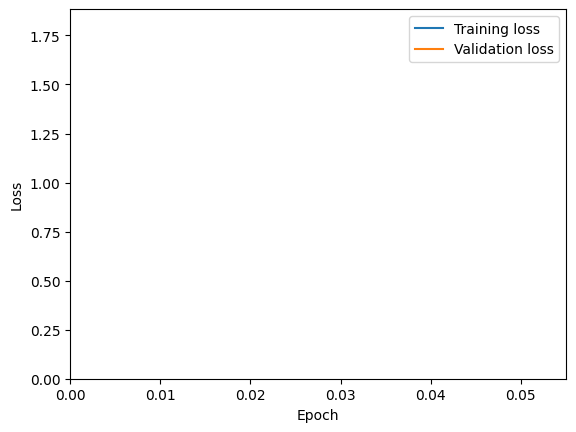

Epoch: 1
Train loss     :  1.8810711506009101
Validation loss:  1.8168941450119018


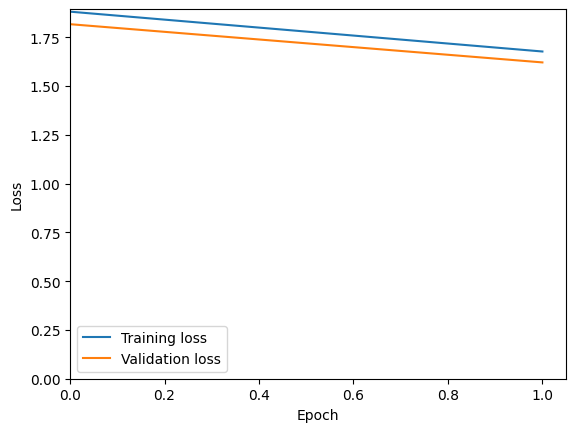

Epoch: 2
Train loss     :  1.6768897554278375
Validation loss:  1.6209949195384978


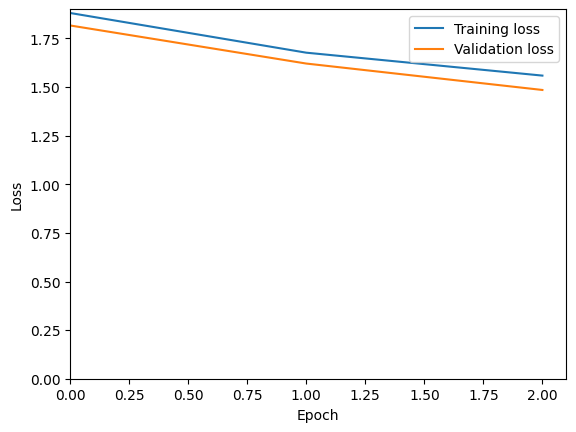

Epoch: 3
Train loss     :  1.5589455300569535
Validation loss:  1.4850631880760192


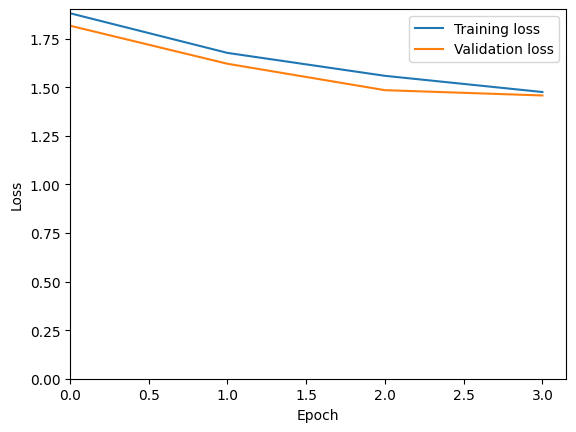

Epoch: 4
Train loss     :  1.4755609801411629
Validation loss:  1.457840223312378


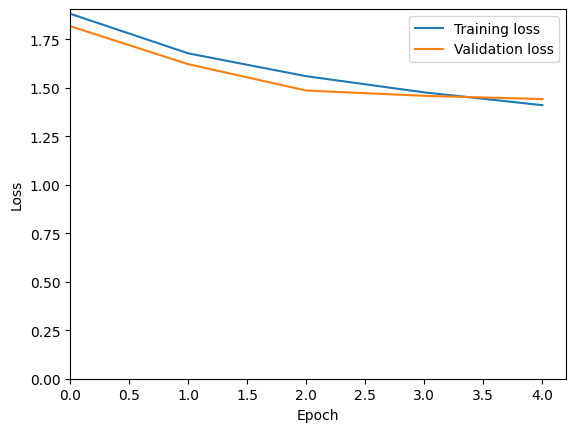

Epoch: 5
Train loss     :  1.4095738795399666
Validation loss:  1.4411471259593964


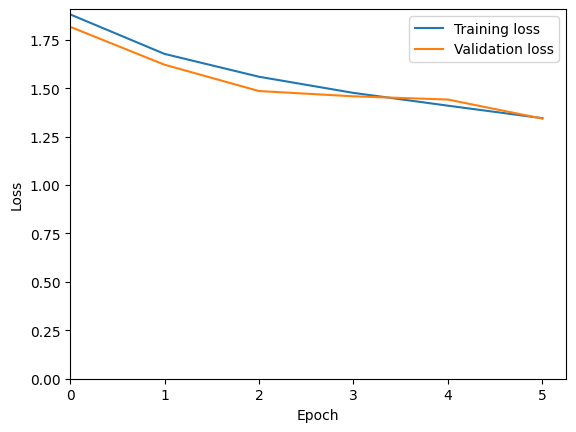

Epoch: 6
Train loss     :  1.3449555197358132
Validation loss:  1.3427310609817504


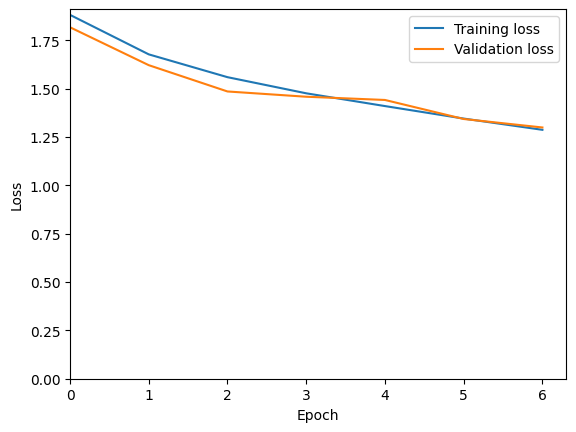

Epoch: 7
Train loss     :  1.2867941291630267
Validation loss:  1.2988793992996215


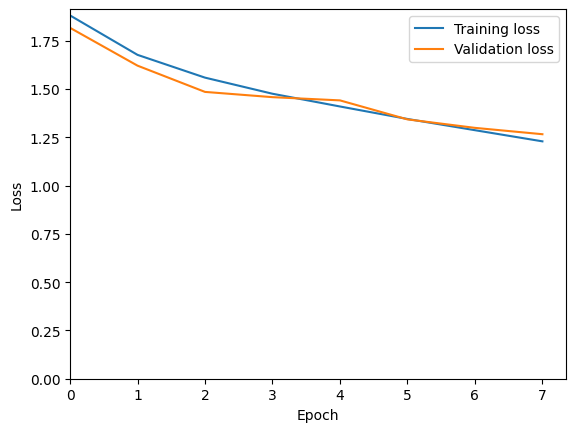

Epoch: 8
Train loss     :  1.2290387535095215
Validation loss:  1.26596351146698


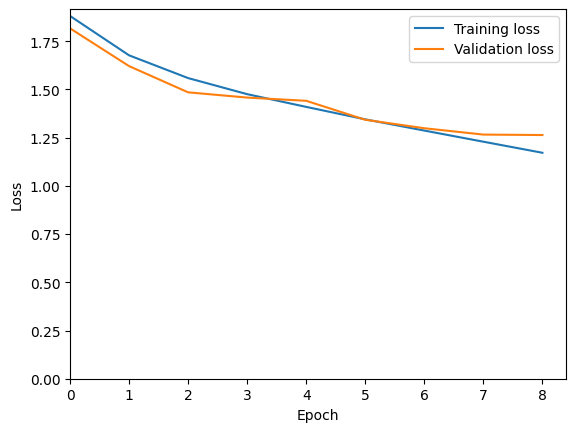

Epoch: 9
Train loss     :  1.1716711609065533
Validation loss:  1.2636089432239532


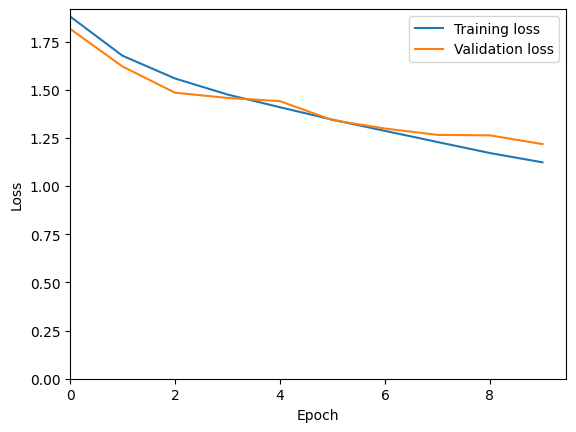

Epoch: 10
Train loss     :  1.1235091005265714
Validation loss:  1.218116506934166


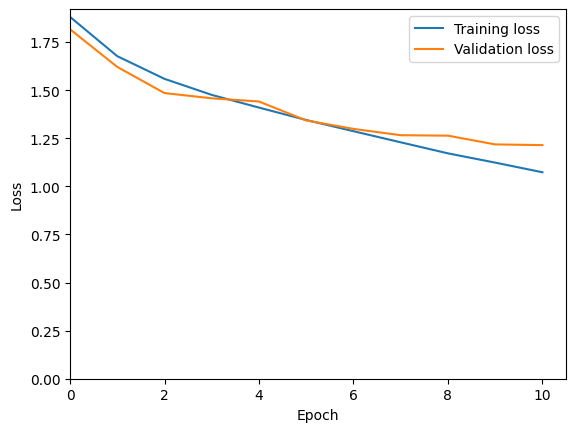

Epoch: 11
Train loss     :  1.0733556838333607
Validation loss:  1.2144721603393556


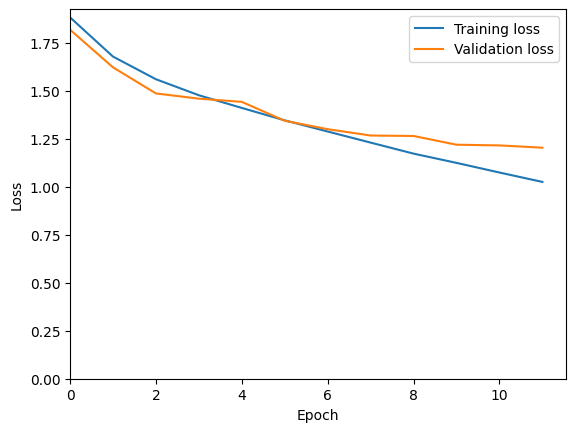

Epoch: 12
Train loss     :  1.02440890699625
Validation loss:  1.2026210230588914


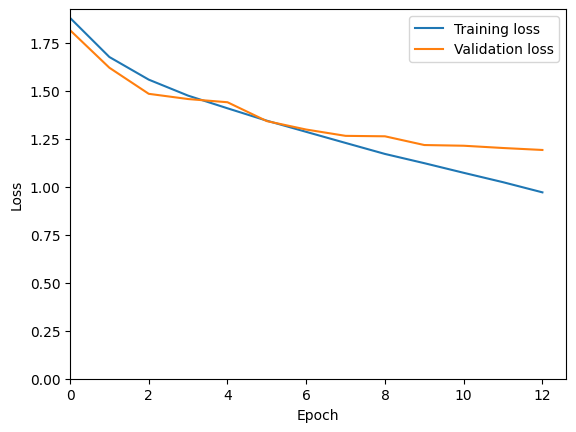

Epoch: 13
Train loss     :  0.9714594034850598
Validation loss:  1.1923680698871613


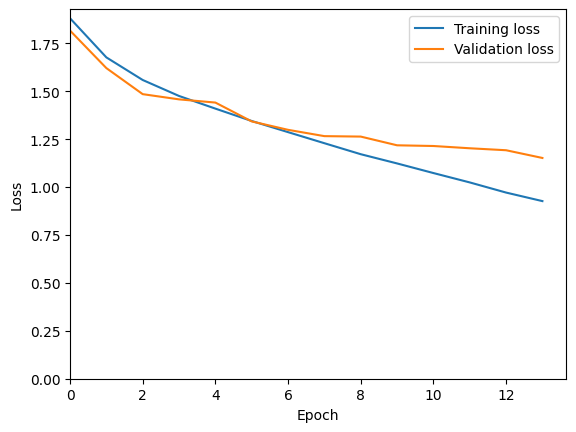

Epoch: 14
Train loss     :  0.9268699418008327
Validation loss:  1.1520404839515686


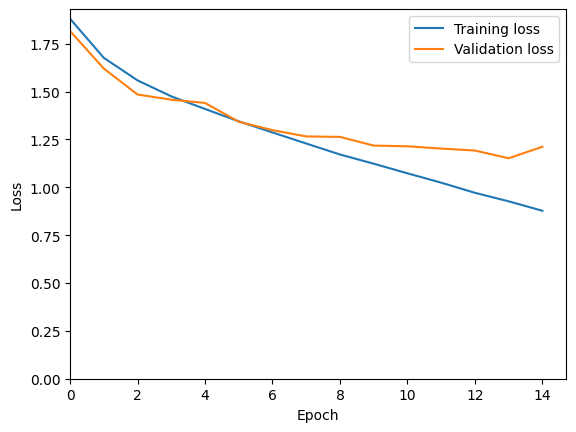

Epoch: 15
Train loss     :  0.8775851276516914
Validation loss:  1.212056010365486
学習終了


In [23]:
max_epoch = 15     # 最大エポック数
patience = 5       # 改善が見られないエポック数の許容回数
trigger_times = 0  # 改善が見られないエポック数のカウンター

best_val_loss = float("inf")  # 初期値として無限大を設定
train_losses = []  # 学習データセットの損失を保存するリスト
val_losses = []  # 検証データセットの損失を保存するリスト

# エポック数のループ
for epoch in range(max_epoch):
    running_loss = 0.0

    # 学習データセットからミニバッチを得るたびに…
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)  # 入力データをGPUに送る
        labels = labels.to(device)  # ラベルをGPUに送る

        optimizer.zero_grad()  # 勾配の初期化

        outputs = net(inputs)  # ネットワークに入力データを渡して出力を取得
        loss = criterion(outputs, labels)  # 損失を計算
        loss.backward()  # 逆伝播を行い、勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss += loss.item()  # ミニバッチの損失を累積

    # エポックごとの訓練データセットに対する平均損失を計算
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # 検証データセットに対する損失を計算
    val_loss = 0.0
    net.eval()  # モデルを評価モードに切り替える
    with torch.no_grad():

        # 検証データセットからミニバッチを得るたびに…
        for data in validationloader:
            images, labels = data
            images = images.to(device)  # 入力データをGPUに送る
            labels = labels.to(device)  # ラベルをGPUに送る

            outputs = net(images)  # ネットワークに入力データを渡して出力を取得
            loss = criterion(outputs, labels)  # 損失を計算
            val_loss += loss.item()  # 損失を累積

    # エポックごとの検証データセットに対する平均損失を計算
    val_loss = val_loss / len(validationloader)
    val_losses.append(val_loss)

    # 損失の値をグラフで表示
    plt.clf()  # 前のグラフをクリア
    plt.plot(train_losses, label='Training loss')  # 訓練データセットの損失
    plt.plot(val_losses, label='Validation loss')  # 検証データセットの損失をプロット
    plt.xlabel('Epoch')  # x軸のラベルを設定
    plt.ylabel('Loss')  # y軸のラベルを設定
    plt.xlim(left=0)  # x軸の表示範囲を設定
    plt.ylim(bottom=0)  # y軸の表示範囲を設定
    plt.legend()  # 凡例を表示
    plt.show()  # グラフを表示

    # エポックごとの損失を出力
    print("Epoch:", epoch + 1)
    print("Train loss     : ", train_loss)
    print("Validation loss: ", val_loss)

    # 検証データセットに対する損失が改善しない場合の処理
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # 最良の検証データセット損失を更新
        trigger_times = 0  # 改善が見られないエポック数をリセット
    else:
        trigger_times += 1  # 改善が見られないエポック数をカウントアップ
        if trigger_times >= patience:  # 許容回数を超えた場合の処理
            print(f"{epoch + 1} エポックで早期終了")  # 早期終了のメッセージを出力
            break  # 学習を終了

print('学習終了')

### テスト

精度を求める処理もまったく同じです。

CIFAR-10 は小規模なデータのため、残念ながら CNN を超える精度は出ないかもしれません。

In [24]:
correct = 0  # 正解数のカウンターを初期化
total = 0  # 全体の画像数のカウンターを初期化

# 訓練モードでの計算を停止（推論モードに切り替える）
with torch.no_grad():
    # テストデータセットに対してループ
    for data in testloader:
        images, labels = data  # ミニバッチごとの画像とラベルを取得
        images = images.to(device)  # GPUに画像を送る
        labels = labels.to(device)  # GPUにラベルを送る

        outputs = net(images)  # ネットワークに画像を入力し、出力を取得
        _, predicted = torch.max(outputs.data, 1)  # 出力の中で最大の値を持つクラスを予測として取得
        total += labels.size(0)  # ミニバッチ内の画像数を全体の画像数に加算
        correct += (predicted == labels).sum().item()  # 予測が正しい場合、正解数をカウントアップ

print('テスト画像における精度 %d %%' % (100 * correct / total))

テスト画像における精度 56 %


### クラスベクトル

ViT の学習が進むと、各クラスごとの **クラスベクトル** ベクトルも、そのクラスを表す値に変わってきます。まずそれ自体を表で確認しましょう。

In [25]:
import pandas as pd

# CIFAR-10のクラス名
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# 学習済みモデルのクラスベクトルを取得
class_vectors = net.linear.weight.data.cpu().numpy()

# クラス番号、クラス名、クラスベクトルをデータフレームに格納
df = pd.DataFrame(class_vectors, columns=[f'Feature_{i+1}' for i in range(class_vectors.shape[1])])
df.insert(0, 'Class Name', classes)
df.insert(0, 'Class Number', range(10))

# データフレームを表示
# import ace_tools as tools; tools.display_dataframe_to_user(name="Class Vectors", dataframe=df)
df

,Class Number,Class Name,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_503,Feature_504,Feature_505,Feature_506,Feature_507,Feature_508,Feature_509,Feature_510,Feature_511,Feature_512
0,0,airplane,0.054491,0.015283,0.008880,-0.018023,-0.036121,-0.013843,-0.018737,-0.036725,...,-0.011749,0.083899,-0.004381,-0.010705,-0.030164,0.036141,-0.020510,0.025629,-0.043255,-0.044325
1,1,automobile,-0.005281,0.061795,0.001000,-0.025228,-0.056168,0.055475,-0.034422,0.056569,...,-0.029400,-0.066910,-0.040832,0.085682,-0.045174,-0.067250,0.046019,-0.035685,0.022948,-0.036064
2,2,bird,0.000272,-0.021256,0.028285,0.047138,-0.000414,-0.062013,0.018124,-0.018286,...,0.020411,0.050522,0.033827,-0.046028,0.023374,-0.017964,0.039534,-0.031785,0.082383,-0.059753
3,3,cat,-0.027789,-0.058979,0.054161,0.022968,-0.017869,-0.031212,0.009968,-0.025630,...,0.046362,-0.028358,-0.000881,0.001068,-0.038719,0.017902,0.019259,-0.043513,-0.038679,-0.020446
4,4,deer,-0.053420,-0.042152,0.027601,0.049374,0.068086,0.071351,-0.022413,0.011967,...,0.001009,-0.002208,-0.025026,-0.032460,0.018904,0.030755,0.003098,0.065273,0.000047,0.021663
5,5,dog,0.018532,-0.016269,0.003527,0.049875,0.020263,-0.016408,-0.034783,0.063880,...,0.002210,0.029404,-0.016232,0.020347,-0.004727,0.033804,-0.019362,0.008738,0.016241,-0.023275
6,6,frog,0.047091,-0.010548,0.018588,-0.020158,0.072620,0.026496,-0.040576,0.024495,...,0.035647,0.028710,0.028602,-0.058379,-0.007770,0.051042,0.028625,-0.034898,0.028931,-0.032253
7,7,horse,-0.049926,-0.027440,0.008686,0.003987,-0.049246,-0.011522,-0.016116,-0.013635,...,0.029289,-0.018336,0.045957,0.005186,0.025312,-0.057878,0.016322,-0.015764,0.003234,-0.011715
8,8,ship,0.065520,-0.052996,-0.034734,0.059216,-0.058469,0.023376,-0.001070,0.015478,...,0.051447,0.021382,0.041696,-0.034306,0.012233,-0.031148,0.000884,-0.021919,0.007266,-0.031258
9,9,truck,-0.038960,-0.000837,-0.001785,-0.039846,-0.007123,0.051713,0.001291,0.035112,...,0.034881,-0.059919,-0.052961,-0.010509,-0.062692,0.018839,0.027499,-0.014890,-0.046273,0.041424


### クラスベクトルによる可視化

ここではクラスベクトルを用いて、入力画像のどの部分がモデルの予測に重要だったか（注意されていたか）をヒートマップで示します。セグメンテーションのように事前に注目箇所を与えて学習するわけではありませんが、Transformerの自己注意機構により、各パッチ間の関係性を学習し、自然に注目箇所が形成されます。各パッチが予測にどの程度寄与しているかを示す注意スコアを計算し、そのスコアを基にヒートマップを生成します。

ここで、ViTにおける自己注意機構をおさらいします：

**クエリ（Query）、キー（Key）、バリュー（Value）の計算**

\begin{align*}
\mathbf{Q} &= \mathbf{X} \mathbf{W_Q}, \
\mathbf{K} &= \mathbf{X} \mathbf{W_K}, \
\mathbf{V} &= \mathbf{X} \mathbf{W_V}
\end{align*}

ここで、$\mathbf{W_Q}$、$\mathbf{W_K}$、$\mathbf{W_V}$
$X$は入力パッチの特徴ベクトル、$\mathbf{W_Q}$、$\mathbf{W_K}$、$\mathbf{W_V}$はそれぞれの重み行列です。

**注意スコアの計算**

\begin{align*}
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) &= \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{D}}\right)\mathbf{V}
\end{align*}
$D$はキーの次元数です。

**クラスベクトルと注意スコアを用いたヒートマップの生成**

クラスベクトルは、各クラスに対応する特徴ベクトルであり、最終的なクラス分類に使用されます。注意スコアとバリュー行列を用いて、画像内の各パッチの重要性を示すヒートマップを生成することができます。具体的には、注意スコア$\alpha_i$と対応するバリューベクトル$\mathbf{V}_i$を掛け合わせて、各パッチの重要度を計算します。

数式では、ヒートマップは次のように計算されます：

\begin{align*}
\text{Heatmap} &= \sum_{i} \alpha_i \mathbf{V}_i
\end{align*}

ここで、$\alpha_i$は注意スコアであり、$\mathbf{V}_i$はバリュー行列$\mathbf{V}$の$i$列目のベクトルです。ヒートマップは、モデルが注目している各パッチの重要性を示します。このヒートマップを視覚化することで、モデルがどの部分に注目しているかを理解することができます。

> <ipython-input-50-3aa2cd3fa7fe>(43)visualize_test_predictions()
     41             # クラスベクトルを除いてリシェイプ
     42             import pdb; pdb.set_trace()
---> 43             heatmap = avg_attn[1:, 1:]  # (64, 64) の形状
     44             heatmap = np.mean(heatmap, axis=0).reshape(patch_size, patch_size)  # (8, 8) の形状に平均化してリシェイプ
     45             heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # 正規化

ipdb> n
> <ipython-input-50-3aa2cd3fa7fe>(44)visualize_test_predictions()
     42             import pdb; pdb.set_trace()
     43             heatmap = avg_attn[1:, 1:]  # (64, 64) の形状
---> 44             heatmap = np.mean(heatmap, axis=0).reshape(patch_size, patch_size)  # (8, 8) の形状に平均化してリシェイプ
     45             heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # 正規化
     46 

ipdb> n
> <ipython-input-50-3aa2cd3fa7fe>(45)visualize_test_predictions()
     43             heatmap = avg_attn[1:, 1:]  # (64, 64) の形状
     44             heatmap = np.


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 347, in set_continue
    sys.settrace(None)



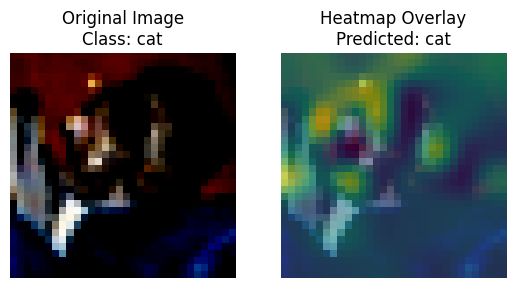

> <ipython-input-50-3aa2cd3fa7fe>(43)visualize_test_predictions()
     41             # クラスベクトルを除いてリシェイプ
     42             import pdb; pdb.set_trace()
---> 43             heatmap = avg_attn[1:, 1:]  # (64, 64) の形状
     44             heatmap = np.mean(heatmap, axis=0).reshape(patch_size, patch_size)  # (8, 8) の形状に平均化してリシェイプ
     45             heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # 正規化

ipdb> c


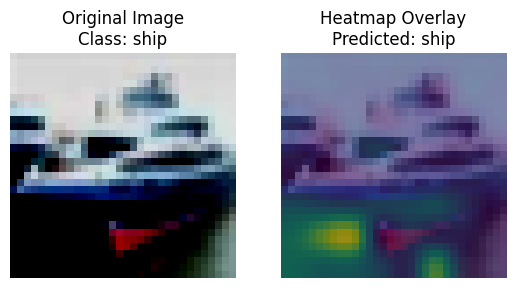

> <ipython-input-50-3aa2cd3fa7fe>(43)visualize_test_predictions()
     41             # クラスベクトルを除いてリシェイプ
     42             import pdb; pdb.set_trace()
---> 43             heatmap = avg_attn[1:, 1:]  # (64, 64) の形状
     44             heatmap = np.mean(heatmap, axis=0).reshape(patch_size, patch_size)  # (8, 8) の形状に平均化してリシェイプ
     45             heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # 正規化



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from PIL import Image

# テストデータの画像を表示し、正解と推定値を表示する関数
def visualize_test_predictions(start_idx, end_idx):
    # テストデータローダーを作成
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

    # 指定したインデックス範囲の画像とラベルを取得
    images, labels = zip(*[(data[0], data[1]) for i, data in enumerate(testloader) if start_idx <= i < end_idx])

    # モデルの予測結果を格納するリストを初期化
    predicted_labels = []

    # 推論モードで計算を停止
    with torch.no_grad():
        # 画像ごとに予測を行う
        for idx, image in enumerate(images):
            image_tensor = image.clone().detach().to(device)  # NumPy配列をテンソルに変換してGPUに送る
            outputs = net(image_tensor)  # ネットワークに画像を入力し、出力を得る
            _, predicted = torch.max(outputs, 1)  # 出力の中で最大の値を持つクラスを予測として取得
            predicted_labels.append(predicted.item())  # 予測結果をリストに追加

            # ヒートマップの計算
            class_vector = net.linear.weight[predicted].cpu().detach().numpy()
            attn = net.layers[0].attention.attn_weights.cpu().detach().numpy()  # attention weights

            # 各ヘッドの注意重みを平均化
            avg_attn = np.mean(attn[0,...

                                    ], axis=0)

            # クラスベクトルを除いたパッチ数を計算
            num_patches = avg_attn.shape[-1] - 1  # クラスベクトルを除く
            patch_size = int(np.sqrt(num_patches))

            if patch_size * patch_size != num_patches:
                raise ValueError(f"Attention weights shape {num_patches} is not a perfect square")

            # クラスベクトルを除いてリシェイプ
            import pdb; pdb.set_trace()
            heatmap = avg_attn[1:, 1:]  # (64, 64) の形状
            heatmap = np.mean(heatmap, axis=0).reshape(patch_size, patch_size)  # (8, 8) の形状に平均化してリシェイプ
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # 正規化

            # ヒートマップを元の画像サイズに補間
            heatmap_resized = np.array(Image.fromarray(np.uint8(255 * heatmap)).resize((32, 32)))

            # オリジナル画像とヒートマップの重畳表示
            image_np = image.cpu().detach().squeeze().permute(1, 2, 0).numpy()
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(image_np)
            ax[0].set_title(f'Original Image\nClass: {classes[labels[idx]]}')
            ax[0].axis('off')

            ax[1].imshow(image_np)
            ax[1].imshow(heatmap_resized, alpha=0.6)
            ax[1].set_title(f'Heatmap Overlay\nPredicted: {classes[predicted]}')
            ax[1].axis('off')

            plt.show()

# 例: インデックス範囲 0 から 5 の画像を表示
visualize_test_predictions(0, 5)


In [29]:
net

ViT(
  (patch_embed): Linear(in_features=48, out_features=512, bias=True)
  (layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (attention): SelfAttention(
        (proj_in): Linear(in_features=512, out_features=1536, bias=False)
        (proj_out): Linear(in_features=512, out_features=512, bias=True)
      )
      (fnn): FNN(
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (activation): GELU(approximate='none')
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)